In [22]:
%matplotlib inline
import pickle as pk
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [3]:
# Load data
file_path = Path("Resources/pickled_raws.pkl")
df = pd.read_pickle(file_path)
df.head()

,agency_code,loan_type,property_type,loan_purpose,owner_occupancy,loan_amount_000s,preapproval,action_taken,msamd,state_code,...,hoepa_status,lien_status,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,action_taken_summary,Region
respondent_id,,,,,,,,,,,,,,,,,,,,,
0000342634,CFPB,Conventional,One to Four-Family,Refinancing,Owner Occupied,9.0,Not Applicable,Application Denied by Financial Institution,33860.0,AL,...,Not a HOEPA Loan,Secured by a Subordinate Loan,1948.0,12.58,59700.0,122.93,507.0,724.0,0,SE
0004186591,CFPB,VA-Guaranteed,One to Four-Family,Home Purchase,Owner Occupied,94.0,Not Applicable,Loan Purchased by the Institution,33860.0,AL,...,Not a HOEPA Loan,Not Applicable (Purchased Loan),1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
22-3039688,HUD,VA-Guaranteed,One to Four-Family,Refinancing,Owner Occupied,161.0,Not Applicable,File Closed for Incompleteness,33860.0,AL,...,Not a HOEPA Loan,Secured by First Lien,1948.0,12.58,59700.0,122.93,507.0,724.0,2,SE
20-3878295,NCUA,Conventional,One to Four-Family,Home Improvement,Owner Occupied,90.0,Not Applicable,Loan Originated,33860.0,AL,...,Not a HOEPA Loan,Secured by First Lien,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
0000342634,CFPB,Conventional,One to Four-Family,Refinancing,Not Owner Occupied,41.0,Not Applicable,Loan Originated,33860.0,AL,...,Not a HOEPA Loan,Secured by First Lien,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE


In [4]:
# Drop undesired columns
df = df.drop(columns=["action_taken", "purchaser_type", "denial_reason_1", "lien_status", "state_code", "hoepa_status", "county_code", "census_tract_number"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13997124 entries, 0000342634 to 0000510871
Data columns (total 23 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   agency_code                     object 
 1   loan_type                       object 
 2   property_type                   object 
 3   loan_purpose                    object 
 4   owner_occupancy                 object 
 5   loan_amount_000s                float64
 6   preapproval                     object 
 7   msamd                           float64
 8   applicant_ethnicity             object 
 9   co_applicant_ethnicity          object 
 10  applicant_race_1                object 
 11  co_applicant_race_1             object 
 12  applicant_sex                   object 
 13  co_applicant_sex                object 
 14  applicant_income_000s           float64
 15  population                      float64
 16  minority_population             float64
 17  hud_median_family_i

In [6]:
# Remove rows containing N/A, incomplete, or irrelevant information
df = df.loc[df["loan_purpose"] == "Home Purchase"]
df = df.drop(columns="loan_purpose")

In [7]:
df = df.loc[df["owner_occupancy"] != "Not Applicable"]

In [8]:
df = df.loc[df["applicant_sex"] != "Information not Provided"]
df = df.loc[df["applicant_sex"] != "Not Applicable"]

In [9]:
df = df.loc[df["co_applicant_sex"] != "Information not Provided"]
df = df.loc[df["co_applicant_sex"] != "Not Applicable"]

In [10]:
df = df.loc[df["applicant_ethnicity"] != "Not Applicable"]
df = df.loc[df["applicant_ethnicity"] != "Info not Provided by Applicant"]

In [11]:
df = df.loc[df["co_applicant_ethnicity"] != "Not Applicable"]
df = df.loc[df["co_applicant_ethnicity"] != "Info not Provided by Applicant"]

In [12]:
df = df.loc[df["preapproval"] != "Not Applicable"]

In [13]:
# Remove outlier homes
df = df.loc[df["loan_amount_000s"] <= 1650]

In [14]:
# Restrict target variable to only approvals and denials
df = df.loc[df["action_taken_summary"] != 2]

In [15]:
df.count()

agency_code                       1700356
loan_type                         1700356
property_type                     1700356
owner_occupancy                   1700356
loan_amount_000s                  1700356
preapproval                       1700356
msamd                             1700356
applicant_ethnicity               1700356
co_applicant_ethnicity            1700356
applicant_race_1                  1700356
co_applicant_race_1               1700356
applicant_sex                     1700356
co_applicant_sex                  1700356
applicant_income_000s             1700356
population                        1700356
minority_population               1700356
hud_median_family_income          1700356
tract_to_msamd_income             1700356
number_of_owner_occupied_units    1700356
number_of_1_to_4_family_units     1700356
action_taken_summary              1700356
Region                            1700356
dtype: int64

In [16]:
# Drop index
df = df.reset_index(drop=True)
df.head()

,agency_code,loan_type,property_type,owner_occupancy,loan_amount_000s,preapproval,msamd,applicant_ethnicity,co_applicant_ethnicity,applicant_race_1,...,co_applicant_sex,applicant_income_000s,population,minority_population,hud_median_family_income,tract_to_msamd_income,number_of_owner_occupied_units,number_of_1_to_4_family_units,action_taken_summary,Region
0,CFPB,FHA-Insured,One to Four-Family,Owner Occupied,92.0,Preapproval Requested,33860.0,Not Hispanic or Latino,No Co-Applicant,Black or African American,...,No Co-Applicant,29.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
1,HUD,VA-Guaranteed,One to Four-Family,Owner Occupied,94.0,Preapproval Not Requested,33860.0,Not Hispanic or Latino,No Co-Applicant,White,...,No Co-Applicant,53.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
2,HUD,FHA-Insured,One to Four-Family,Owner Occupied,147.0,Preapproval Not Requested,33860.0,Not Hispanic or Latino,Not Hispanic or Latino,White,...,Female,90.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE
3,HUD,FHA-Insured,One to Four-Family,Owner Occupied,115.0,Preapproval Not Requested,33860.0,Not Hispanic or Latino,No Co-Applicant,White,...,No Co-Applicant,30.0,1948.0,12.58,59700.0,122.93,507.0,724.0,0,SE
4,HUD,VA-Guaranteed,One to Four-Family,Owner Occupied,160.0,Preapproval Not Requested,33860.0,Not Hispanic or Latino,No Co-Applicant,White,...,No Co-Applicant,50.0,1948.0,12.58,59700.0,122.93,507.0,724.0,1,SE


In [17]:
# Reduce to income and action
income_df = df[["action_taken_summary", "applicant_income_000s"]]
income_df.head()

,action_taken_summary,applicant_income_000s
0,1,29.0
1,1,53.0
2,1,90.0
3,0,30.0
4,1,50.0


In [35]:
income_df.describe()["applicant_income_000s"]

count    1.700356e+06
mean     1.000876e+02
std      1.452019e+02
min      0.000000e+00
25%      5.100000e+01
50%      7.600000e+01
75%      1.170000e+02
max      9.854400e+04
Name: applicant_income_000s, dtype: float64

In [65]:
def GetCountGraph(df, application_outcome, outcome_keys):
    # Setting the ranges for our income bands
    bins = [0, 40, 80, 120, 200, 500, 100000]
    # Creating labels for our ranges
    labels = ['0-$40k', '$40k-80k', '$80k-$120k', '$120k-$200k', '$200k-$500k', '$500k+']
    # Create the income bins
    df['income_band']= pd.cut(x=df['applicant_income_000s'], bins=bins, labels=labels)
  
    # Create a map so we can order our x-ticks in the graph
    label_order_dict = {'0-$40k':0,
                        '$40k-80k':1, 
                        '$80k-$120k':2, 
                        '$120k-$200k':3, 
                        '$200k-$500k':4, 
                        '$500k+':5}

    # Create a numerical column that holds the order of the income bands
    df['income_band_order'] = df['income_band'].map(label_order_dict)
    ####print(df['income_band_order'])
    # Subset data for the desired application outcome
    approvals_df = df[df['action_taken_summary'].isin(outcome_keys)]

    # Getting counts of applications per income band
    counts_df = pd.DataFrame(approvals_df['income_band_order'].value_counts())

    # Build a table for plotting
    plot_df = counts_df.reset_index()
    plot_df.columns = ['Income Band', f'# of {application_outcome}']
    plot_df = plot_df.sort_values(by = 'Income Band')
    
    #Add labels for the amounts
    # def addlabels(plot_df,x,y):
        # for i in x.index:
        #     #print(i,y[i])
        #     plt.text(i, y[i], y[i], ha = 'center')


    # Plotting
    fig, ax = plt.subplots();
    ax.bar(plot_df['Income Band'], plot_df[f'# of {application_outcome}']);
    ax.set_xticks([0,1,2,3,4,5], labels=labels);
    plt.title(f'Number of {application_outcome} by Income Level');
    plt.xticks(rotation = 45);
    plt.xlabel('Income Band');
    plt.ylabel(f'# of {application_outcome}');
    
    # addlabels(labels, plot_df[f'# of {application_outcome}']);

    for x, y in enumerate(plot_df[f'# of {application_outcome}']):
        ax.text(x-.35, y+3150, str(y), fontsize=10)
    
    plt.show();

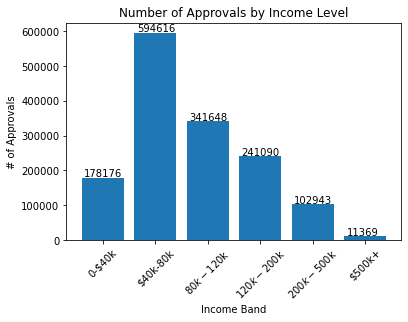

In [66]:
GetCountGraph(df, "Approvals", [1])

In [74]:
def GetCountGraph2(df, application_outcome, outcome_keys):
    # Setting the ranges for our income bands
    bins = [0, 40, 80, 120, 200, 500, 100000]
    # Creating labels for our ranges
    labels = ['0-$40k', '$40k-80k', '$80k-$120k', '$120k-$200k', '$200k-$500k', '$500k+']
    # Create the income bins
    df['income_band']= pd.cut(x=df['applicant_income_000s'], bins=bins, labels=labels)
  
    # Create a map so we can order our x-ticks in the graph
    label_order_dict = {'0-$40k':0,
                        '$40k-80k':1, 
                        '$80k-$120k':2, 
                        '$120k-$200k':3, 
                        '$200k-$500k':4, 
                        '$500k+':5}

    # Create a numerical column that holds the order of the income bands
    df['income_band_order'] = df['income_band'].map(label_order_dict)
    ####print(df['income_band_order'])
    # Subset data for the desired application outcome
    approvals_df = df[df['action_taken_summary'].isin(outcome_keys)]

    # Getting counts of applications per income band
    counts_df = pd.DataFrame(approvals_df['income_band_order'].value_counts())

    # Build a table for plotting
    plot_df = counts_df.reset_index()
    plot_df.columns = ['Income Band', f'# of {application_outcome}']
    plot_df = plot_df.sort_values(by = 'Income Band')
    
    #Add labels for the amounts
    # def addlabels(plot_df,x,y):
        # for i in x.index:
        #     #print(i,y[i])
        #     plt.text(i, y[i], y[i], ha = 'center')


    # Plotting
    fig, ax = plt.subplots();
    ax.bar(plot_df['Income Band'], plot_df[f'# of {application_outcome}']);
    ax.set_xticks([0,1,2,3,4,5], labels=labels);
    plt.title(f'Number of {application_outcome} by Income Level');
    plt.xticks(rotation = 45);
    plt.xlabel('Income Band');
    plt.ylabel(f'# of {application_outcome}');
    
    # addlabels(labels, plot_df[f'# of {application_outcome}']);

    for x, y in enumerate(plot_df[f'# of {application_outcome}']):
        ax.text(x-.3, y+400, str(y), fontsize=10)
    
    plt.show();

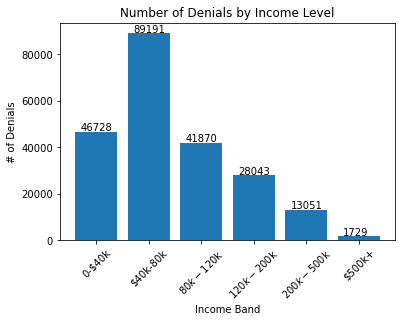

In [75]:
GetCountGraph2(df, "Denials", [0])